In [192]:
import occultation_package as occ
from scipy.fft import fft, ifft
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.fft import fftfreq
import scipy.signal as signal

In [193]:
density_profiles = []
#Holds a list of column densities
density_fft = []
#A list of ffts of those column densities
file_id = []
#A list of file names
height = []
inv_height = []
cd = []
wave = occ.new_wave

N = 275
T = 1.0 / 800.0
#FFT spacing parameters

multi_files = open('scans_with_multiple_occultation.txt')
ms = multi_files.readlines()
ms= [i.strip('\n') for i in ms]
#Makes the multi_files readable

num_occ = len(occ.files)
#The length of files list in the occultation package

plt.figure()

def cd_height(X, a, b, c):
    r,s = X
    if sigma == 0:
        pass
    else:
        column_density = (-np.log(r)/s) * a * b * c
        return column_density.reshape(128)

for i in range(num_occ):
    if occ.files[i].name in ms:
        pass
    else:   
        density = occ.get_cd(occ.files[i], plot = (i % 1000 == 0))
        cd = density[0].tolist()
        height = density[1]
        inv_height = np.reciprocal(height)
        sigma = density[3].astype(float)
        ratio = density[4].astype(float)
        cd_h = cd_height((ratio, sigma), 1, 1, 1)
        if height.shape[0] > 0:
            print(height)
            plt.plot(sigma, cd_h, 'b-', label='data')
            plt.show()
        #if i % 100 == 0:
            #f, Pper_spec = signal.periodogram(cd, 1, 'flattop', scaling='spectrum')
            #plt.figure()
            #plt.semilogy(f, Pper_spec)
            #plt.show()
            #plt.plot(height, fft(cd))
            #plt.xlim(0, 300)
            #plt.ylim(-10**19, 10**19)
            #plt.xlabel('Inverse Tangent Height, (Vertical Frequency) (km^-1)')
            #plt.ylabel('Column Density')
            #plt.title('FFT of Column Density vs Tangent Height')
            #plt.figure()
            #plt.plot(ifft(fft(cd)), height)
            #plt.xlabel('Column Density')
            #plt.ylabel('Tangent Height (km)')
            #plt.title('IFFT of Column Density vs Tangent Height')
            #plt.xlim(0, 1*(10**18))
        density_profiles.append(cd)
        file_id.append(occ.files[i].name)
        #if cd.shape[0] > 0:
        #density_fft.append(fft(cd))
        #tan_height.append(height)
        #else:
           #density_fft.append(None)
            #tan_height.append(None)
  
#plt.plot(height, column_density, 'b-', label='data')

#print(density_profiles)
#print(density_fft)
#print(tan_height)


#plt.show()

#occ.smooth_cd(occ.files[0])


ValueError: cannot reshape array of size 102 into shape (128,)

<Figure size 640x480 with 0 Axes>

None


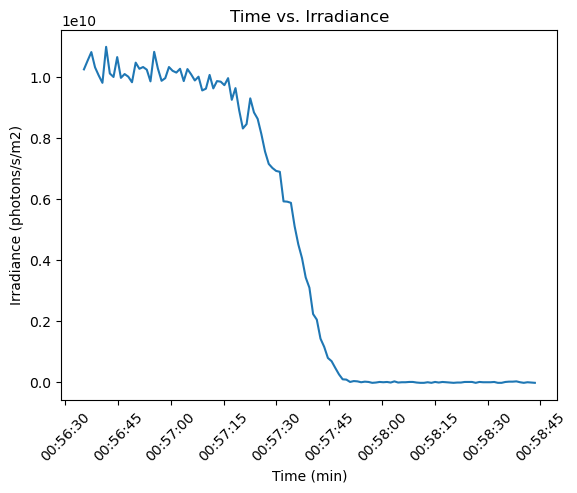

In [90]:
irr = occ.irradiance(occ.files[600])
print(irr)